# Anomaly Detection Darts Module

The scope of this jupyter notebook is to present the different functionalities of the anomaly detection module. The anomaly detection module comprises 4 submodules: Anomaly Scorers, Detectors, Aggregators and Anomaly Models. The submodules are defined as follows: 

- `Scorers`: produce anomaly scores time series, either for single series or for series accompanied by some predictions. They are the core of the anomaly detection module.
    
- `Detectors`: transform time series (such as anomaly scores) into binary anomaly time series. Following the convention found in most of the literature, Darts flags the presence of an anomaly with the value 1 and 0 otherwise. 
    
- `Aggregators`: reduce a multivariate binary time series (e.g., where each component represents the anomaly score of a different series component/model) into a univariate binary time series. 

- `Anomaly Models`: offer a convenient way to produce anomaly scores from any Darts forecasting or filtering models by comparing the models’ predictions with actual observations. It takes as parameters one Darts model and one or multiple scorers. The model produces some predictions, which are fed together with the actual series to the scorer(s). It will return an anomaly score for each scorer. 

The following figure illustrates the different input/output of the submodules:

<img src="static/images/ad_4_sub_modules.png" width="800"> 




In this notebook, we will showcase the different submodules. It is subdivided into two sections:
- We show the application of a `forecasting anomaly model` on a dataset representing the number of taxi passengers in New York. 
- We showcase the utility of the window parameter while applying a `KMeansScorer` on two toy datasets. 

First, some necessary imports:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import datetime
from ipywidgets import interact, widgets

from darts import TimeSeries
from darts.ad.utils import (
    show_anomalies_from_scores,
    eval_accuracy_from_scores,
    eval_accuracy_from_binary_prediction,
)
from darts.ad.anomaly_model.forecasting_am import ForecastingAnomalyModel
from darts.ad.scorers import KMeansScorer, WassersteinScorer, NormScorer
from darts.models import RegressionModel
from darts.datasets import TaxiNewYorkDataset
from darts.metrics import mae, rmse

# Anomaly Model: Taxi passengers in NY

## Load and visualize the data 


Information on the data:
- Univariate Time Series (represents the number of taxi passengers in New York)
- During a period of 8 months (2014-07 to 2015-01)
- Frequency of 30 minutes 

In this example, anomalies are subjective. It can be defined as periods where the demand for taxis is abnormal (different than what should be expected). Based on this definition, the following five dates can be considered anomalies:

- NYC Marathon - 2014-11-02
- Thanksgiving - 2014-11-27
- Christmas - 2014-12-24/25
- New Years - 2015-01-01
- Snow Blizzard - 2015-01-26/27

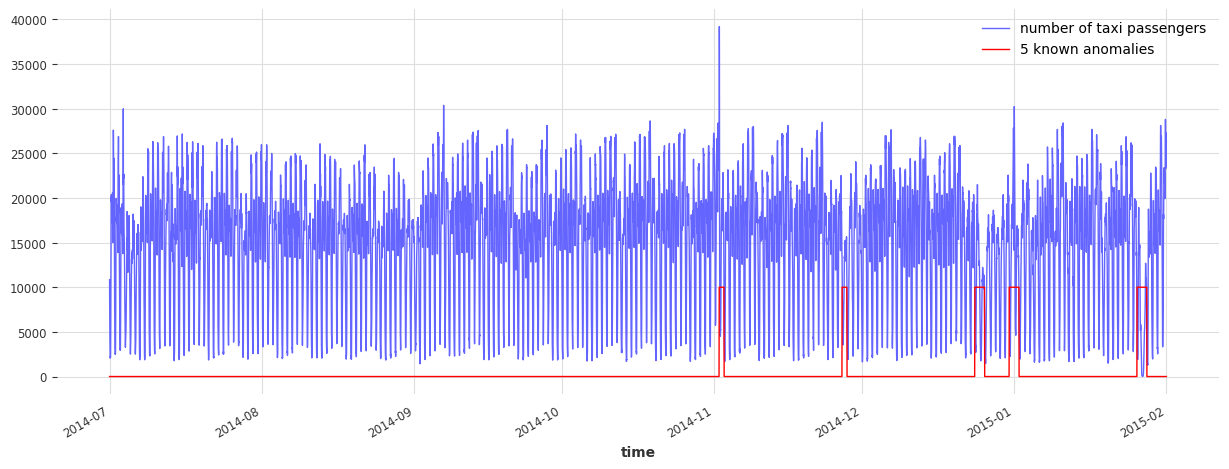

In [5]:
# load the data
series_taxi = TaxiNewYorkDataset().load()

# 5 anomalies, which corresponds to 8 anomalous days (some anomalies span two days)
anomalies_day = {
    "NYC Marathon": {
        "start_date": datetime.date(2014, 11, 2),
        "duration": 1,
    },  # duration is in days
    "Thanksgiving ": {"start_date": datetime.date(2014, 11, 27), "duration": 1},
    "Christmas": {"start_date": datetime.date(2014, 12, 24), "duration": 2},
    "New Years": {"start_date": datetime.date(2014, 12, 31), "duration": 2},
    "Snow Blizzard": {"start_date": datetime.date(2015, 1, 26), "duration": 2},
}

list_anomalies_day = sum(
    [
        [
            (anomaly["start_date"] + datetime.timedelta(days=day))
            for day in range(anomaly["duration"])
        ]
        for anomaly in anomalies_day.values()
    ],
    [],
)

# 1: anomalous signal, 0: normal signal
anomalies = np.where(
    np.isin(series_taxi.pd_dataframe().index.date, list_anomalies_day), 1, 0
)

# create binary timeseries indicating the presence of the anomalies
series_taxi_anomalies = TimeSeries.from_times_and_values(
    series_taxi.time_index, anomalies
)

# plot the data and the anomalies
fig, ax = plt.subplots(figsize=(15, 5))
series_taxi.plot(label="Number of taxi passengers", linewidth=1, color="#6464ff")
(series_taxi_anomalies * 10000).plot(label="5 known anomalies", color="r", linewidth=1)
plt.show()

In [6]:
style = {"description_width": "initial"}
anomalies_dropdown = widgets.Dropdown(options=anomalies_day.keys(), style=style)
delta_plotted_days = widgets.IntSlider(value=3, min=1, max=25, style=style)


@interact(selected_anomaly=anomalies_dropdown, delta_plotted_days=delta_plotted_days)
def plot(selected_anomaly, delta_plotted_days):
    anomaly_date = anomalies_day[selected_anomaly]["start_date"]
    start_timestamp = pd.Timestamp(
        anomaly_date - datetime.timedelta(days=delta_plotted_days)
    )
    end_timestamp = pd.Timestamp(
        anomaly_date + datetime.timedelta(days=delta_plotted_days + 1)
    )

    series_taxi.slice(start_timestamp, end_timestamp).plot(
        label="Number of taxi passengers", color="#6464ff", linewidth=0.8
    )

    (series_taxi_anomalies.slice(start_timestamp, end_timestamp) * 10000).plot(
        label="Known anomaly", color="r", linewidth=0.8
    )

    plt.title(selected_anomaly)
    plt.show()

interactive(children=(Dropdown(description='selected_anomaly', options=('NYC Marathon', 'Thanksgiving ', 'Chri…

The goal would be to detect these five irregular periods and identify other possible abnormal days. 

## Train a darts forecasting model

We will use a `RegressionModel` to predict the number of taxi passengers. The first 4500 timestamps will be used to train the model. The training set is considered to be anomaly-free, the five considered anomalies are located after the 4500th timestamps. The number of lags is set to 1 week, assuming the demand follows a periodicity of 1 week. To help the model, additional information on the targeted series is passed as covariates (timestamp’s hour and the day of the week).


In [8]:
# split the data in a training and testing set
s_taxi_train = series_taxi[:4500]
s_taxi_test = series_taxi[4500:]

# Add covariates (hour and day of the week)
add_encoders = {
    "cyclic": {"future": ["hour", "dayofweek"]},
}

# one week corresponds to (7 days * 24 hours * 2) of 30 minutes
one_week = 7 * 24 * 2

forecasting_model = RegressionModel(
    lags=one_week, lags_future_covariates=[0], add_encoders=add_encoders
)
forecasting_model.fit(s_taxi_train);

## Use a Forecasting Anomaly Model 

The anomaly model consists of two inputs:
- a fitted forecasting darts model (if not fitted, the parameter `allow_model_training` needs to be set to `True`)
- a list of scorers (trainable or not)

For this example, three scorers will be used:
- `NormScorer` (window is by default set to 1)
- `WassersteinScorer` with a window set at half a day (24 timestamps)
- `WassersteinScorer` with a window set at a full day (48 timestamps)

The window parameter is an integer value indicating the window size used by the scorer to transform the series into an anomaly score. A scorer will slice the given series into subsequences of size W and returns a value indicating how anomalous these subset of W values are.

The following figure illustrates the mechanism of a Forecasting Anomaly model:

<img src="static/images/ad_inside_anomaly_model.png" width="800"> 



### Using the main functions: fit(), score(), eval_accuracy() and show_anomalies()

In [9]:
# with timestamps of 30 minutes
half_a_day = 2 * 12
full_day = 2 * 24

# instantiate the anomaly model with: one fitted model, and 3 scorers
anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
        NormScorer(ord=1),
        WassersteinScorer(window=half_a_day),
        WassersteinScorer(window=full_day),
    ],
)

The ForecastingAnomalyModel can be fitted by calling `fit()`. It will first fit the forecasting model on the given series (if not fitted yet, and if the parameter `allow_model_training` is set to `True`). Secondly, the scorers will be fitted on the model's prediction of the given input. 


The parameter `start` indicates the fraction of the input series after which the scorers should be trained on. The parameter is set to 0.1. A larger value would mean the model is trained on a smaller subset but a more recent sub-series. On the other hand, a smaller value would imply a bigger training set, but there is a risk of using older parts of the series. The parameter must be carefully chosen, as the model requires a minimum amount of lags to make its first prediction; the start value cannot be lower than this corresponding value.


In [10]:
START = 0.1
anomaly_model.fit(s_taxi_train, start=START, allow_model_training=False);

We call the function `score()` to test our anomaly model. It returns `anomaly_scores`, the three anomaly scores generated by the scorers of the anomaly model for the series `s_taxi_test`. We will use the results in the next section. The parameter `return_model_prediction` is set to True, which indicates to the anomaly model to return the prediction `model_forecasting` of the forecasting model of the series `s_taxi_test`.


In [11]:
anomaly_scores, model_forecasting = anomaly_model.score(
    s_taxi_test, start=START, return_model_prediction=True
)

On testing set -> MAE: 595.1903662620488, RMSE: 896.6287614972357


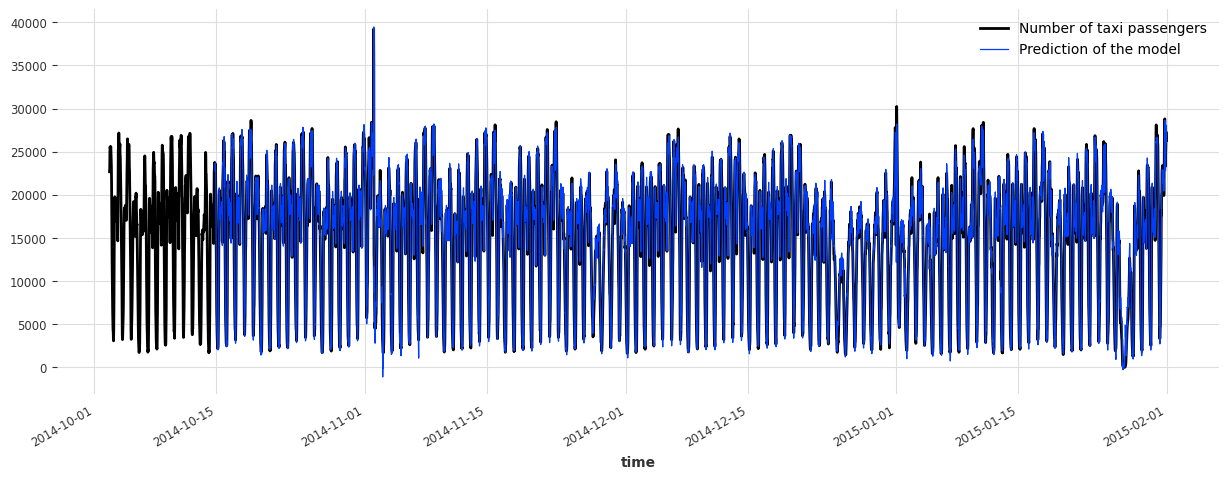

In [32]:
# compute the MAE and RMSE on the test set
print(
    "On testing set -> MAE: {}, RMSE: {}".format(
        mae(model_forecasting, s_taxi_test), rmse(model_forecasting, s_taxi_test)
    )
)

# plot the data and the anomalies
fig, ax = plt.subplots(figsize=(15, 5))
s_taxi_test.plot(label="Number of taxi passengers")
model_forecasting.plot(label="Prediction of the model", linewidth=0.9)
plt.show()

To quantify the success of the anomaly model, we call the function `eval_accuracy()`. It outputs the score of an agnostic threshold metric ("AUC-ROC" or "AUC-PR"), between the predicted anomaly score time series and some known binary ground-truth time series indicating the presence of actual anomalies. 

It will return a dictionary containing the name of the scorer and its score.

In [17]:
auc_roc_taxi = anomaly_model.eval_accuracy(
    actual_anomalies=series_taxi_anomalies,
    series=s_taxi_test,
    start=START,
    metric="AUC_ROC",
)
auc_pr_taxi = anomaly_model.eval_accuracy(
    actual_anomalies=series_taxi_anomalies,
    series=s_taxi_test,
    start=START,
    metric="AUC_PR",
)

#  Values are rounded off to 3 decimal places.
print("AUC ROC:", {scorer: round(auc_roc_taxi[scorer], 3) for scorer in auc_roc_taxi})
print("AUC PR:", {scorer: round(auc_pr_taxi[scorer], 3) for scorer in auc_pr_taxi})

AUC ROC: {'Norm (ord=1)_w=1': 0.658, 'WassersteinScorer_w=24': 0.885, 'WassersteinScorer_w=48': 0.9}
AUC PR: {'Norm (ord=1)_w=1': 0.216, 'WassersteinScorer_w=24': 0.609, 'WassersteinScorer_w=48': 0.707}


We can see that the anomaly model, using the `WassersteinScorer`, can separate the abnormal days from the normal ones. The AUC ROC is above 0.9. Additionally, a window of size 48 timestamps (24 hours) is a better option than a window of size 24 timestamps (12 hours). 

We call the function `show_anomalies()` to visualize the results. It plots the scorer’s prediction, the input series, and the actual values. The scorers with different windows will be separated. It is possible to compute a metric that will be shown next to the scorer’s name. 

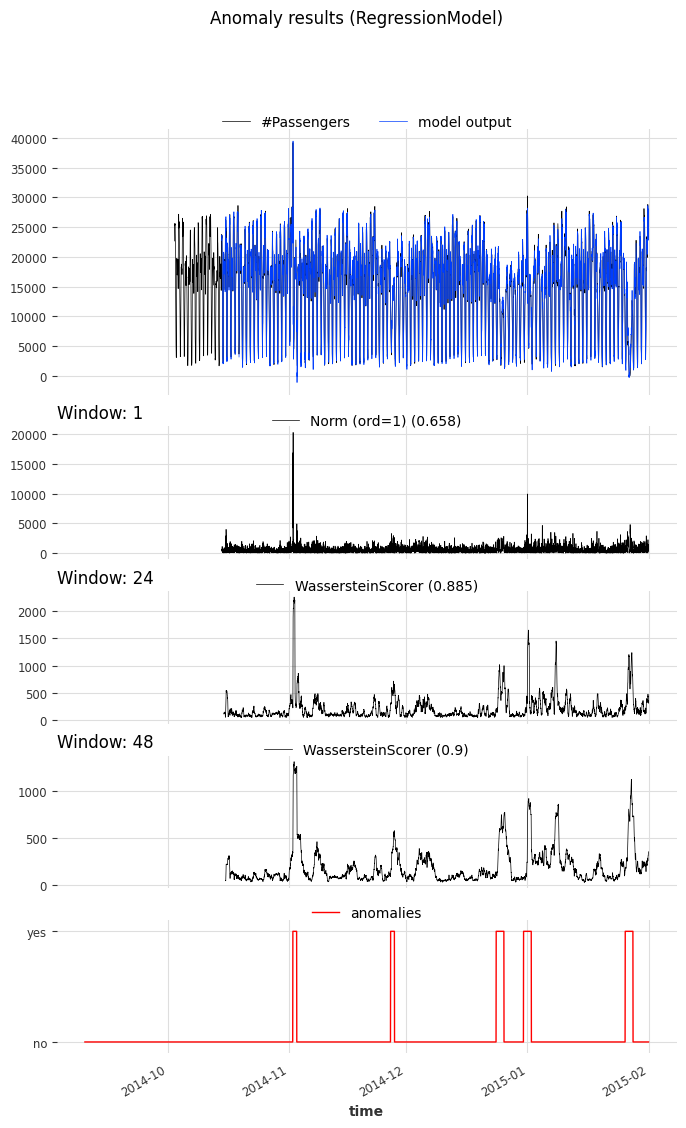

In [18]:
anomaly_model.show_anomalies(
    series=s_taxi_test,
    actual_anomalies=series_taxi_anomalies[3400:],
    start=START,
    metric="AUC_ROC",
)
plt.show()

# Convert an anomaly score to a binary prediction with a `Detector`

The module offers Detectors to convert an anomaly score into a binary prediction. In this example, we will use the fittable detector: `QuantileDetector`. 

It is a detector that detects anomalies based on quantiles of historical data. It compares time series values with user-specified quantiles of historical data (`high_quantile` and/or `low_quantile`) and identifies time points as anomalous when values exceed thresholds. In this example, the anomaly score is the absolute residual of the model. It is lower bound by 0. We will leave `low_quantile` to None, as we only want to flag the values above a certain threshold. 

We set `high_quantile` to 0.95. This value must be chosen carefully, as it will convert the (1- `high_quantile`) * 100  % biggest anomaly scores into a prediction of anomalies. In our case, we want to see the 5% most anomalous timestamps. 

In [28]:
from darts.ad.detectors import QuantileDetector

contamination = 0.95
detector = QuantileDetector(high_quantile=contamination)

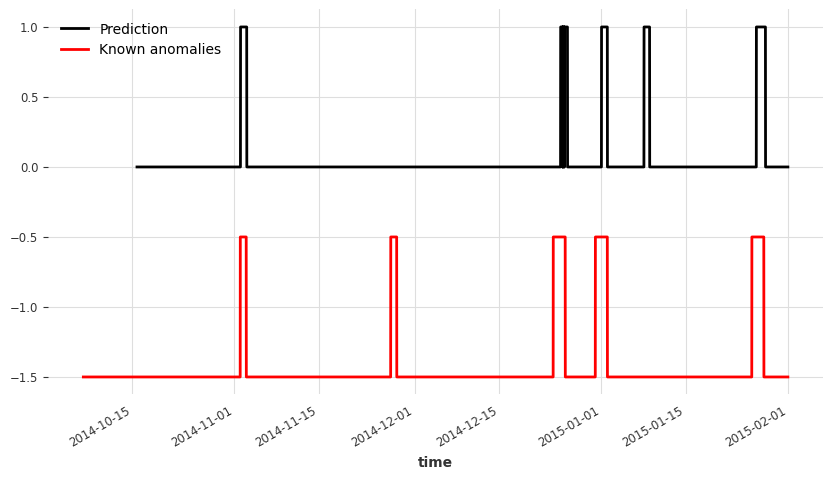

In [33]:
# use the anomaly score that gave the best AUC ROC score: Wasserstein anomaly score with a window of 'full_day'
best_anomaly_score = anomaly_scores[2]

# fit and detect on the anomaly score, it will return a binary prediction
anomaly_prediction = detector.fit_detect(series=best_anomaly_score)

# plot the binary prediction
fig, ax = plt.subplots(figsize=(10, 5))
anomaly_prediction.plot(label="Prediction")
(series_taxi_anomalies[4700:] - 1.5).plot(label="Known anomalies", color="red")
plt.show()

In [30]:
accuracy = detector.eval_accuracy(
    anomaly_score=best_anomaly_score,
    actual_anomalies=series_taxi_anomalies,
    window=full_day,
    metric="accuracy",
)
precision = detector.eval_accuracy(
    anomaly_score=best_anomaly_score,
    actual_anomalies=series_taxi_anomalies,
    window=full_day,
    metric="precision",
)
recall = detector.eval_accuracy(
    anomaly_score=best_anomaly_score,
    actual_anomalies=series_taxi_anomalies,
    window=full_day,
    metric="recall",
)
f1 = detector.eval_accuracy(
    anomaly_score=best_anomaly_score,
    actual_anomalies=series_taxi_anomalies,
    window=full_day,
    metric="f1",
)

print(
    "accuracy: {:.2f}/1, precision: {:.2f}/1, recall: {:.2f}/1 and f1: {:.2f}/1".format(
        accuracy, precision, recall, f1
    )
)

accuracy: 0.91/1, precision: 0.83/1, recall: 0.35/1 and f1: 0.49/1


### Using the functions show_anomalies_from_scores(), eval_accuracy_from_scores()

The functions `eval_accuracy()` and `show_anomalies()` call internaly `eval_accuracy_from_scores()` and `show_anomalies_from_scores()`, respectively. Both are located in the `utils.py` file of the anomaly detection module. They can be called directly if we have already computed the scores with the function `score()`. 

The following cells recreate the metric values and the plot seen previously by calling the two functions. 

To compute the accuracy, the `function eval_accuracy_from_scores()` requires the window size value for the scores. It was previously accessed by the function `eval_accuracy()` in the Forecasting anomaly model. Therefore, we must indicate what window was used to compute each score manually. In our case, it is 1, 24 (`half_a_day`), and 48 (`full_day`). 

In [31]:
auc_roc_taxi_from_scores = eval_accuracy_from_scores(
    actual_anomalies=series_taxi_anomalies,
    anomaly_score=anomaly_scores,
    window=[1, half_a_day, full_day],
    metric="AUC_ROC",
)
auc_pr_taxi_from_scores = eval_accuracy_from_scores(
    actual_anomalies=series_taxi_anomalies,
    anomaly_score=anomaly_scores,
    window=[1, half_a_day, full_day],
    metric="AUC_PR",
)

names_of_scorers = [
    "Norm (ord=1)_w=1",
    "WassersteinScorer_w=24",
    "WassersteinScorer_w=48",
]

print(
    "AUC ROC:",
    [
        (name_of_scorer, round(item, 3))
        for name_of_scorer, item in zip(names_of_scorers, auc_roc_taxi_from_scores)
    ],
)
print(
    "AUC PR:",
    [
        (name_of_scorer, round(item, 3))
        for name_of_scorer, item in zip(names_of_scorers, auc_pr_taxi_from_scores)
    ],
)

AUC ROC: [('Norm (ord=1)_w=1', 0.658), ('WassersteinScorer_w=24', 0.885), ('WassersteinScorer_w=48', 0.9)]
AUC PR: [('Norm (ord=1)_w=1', 0.216), ('WassersteinScorer_w=24', 0.609), ('WassersteinScorer_w=48', 0.707)]


As expected, the AUC ROC and AUC PR values are identical to those found with the function `eval_accuracy()`.

Regarding the function `eval_accuracy_from_scores()`, if we want to compute a metric, we also need to specify the window of each score. Additionally, we can indicate the scorers’ names that generated the scores. 

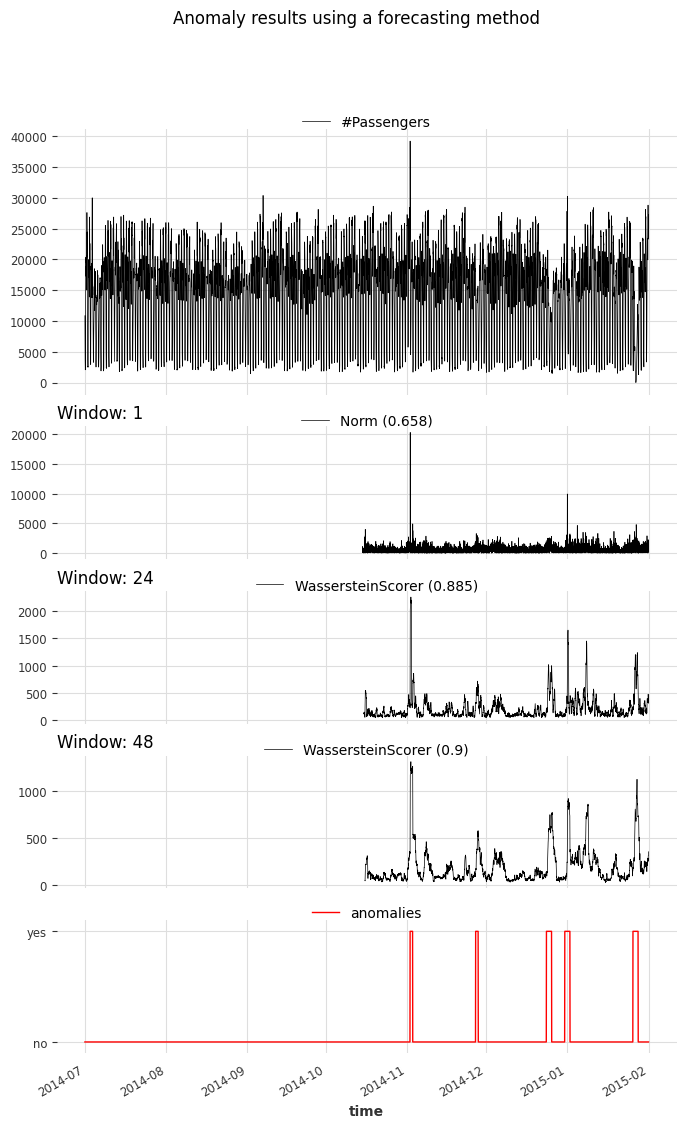

In [14]:
show_anomalies_from_scores(
    series=series_taxi,
    actual_anomalies=series_taxi_anomalies,
    anomaly_scores=anomaly_scores,
    window=[1, half_a_day, full_day],
    title="Anomaly results using a forecasting method",
    names_of_scorers=["Norm", "WassersteinScorer", "WassersteinScorer"],
    metric="AUC_ROC",
)
plt.show()

# A zoom on each anomalies: visualize the results

In [34]:
style = {"description_width": "initial"}
anomalies_dropdown = widgets.Dropdown(options=anomalies_day.keys(), style=style)
delta_plotted_days = widgets.IntSlider(value=3, min=1, max=25, style=style)

# function to normalize a series between 1 and 0
def normalize(series):
    return (series - series.min(axis=0).all_values()[0][0][0]) / (
        series.max(axis=0).all_values()[0][0][0]
        - series.min(axis=0).all_values()[0][0][0]
    )


@interact(selected_anomaly=anomalies_dropdown, delta_plotted_days=delta_plotted_days)
def plot(selected_anomaly, delta_plotted_days):
    anomaly_date = anomalies_day[selected_anomaly]["start_date"]
    start_timestamp = pd.Timestamp(
        anomaly_date - datetime.timedelta(days=delta_plotted_days)
    )
    end_timestamp = pd.Timestamp(
        anomaly_date + datetime.timedelta(days=delta_plotted_days + 1)
    )

    series_taxi.slice(start_timestamp, end_timestamp).plot(
        label="Number of taxi passengers", color="#6464ff", linewidth=0.8
    )

    model_forecasting.slice(start_timestamp, end_timestamp).plot(
        label="Model prediction", color="green", linewidth=0.8
    )

    (series_taxi_anomalies.slice(start_timestamp, end_timestamp) * 10000).plot(
        label="Known anomaly", color="r", linewidth=0.8
    )

    (normalize(best_anomaly_score).slice(start_timestamp, end_timestamp) * 10000).plot(
        label="Anomaly score", color="black", linewidth=0.8
    )

    plt.legend(loc="upper center", ncols=2)
    plt.title(selected_anomaly)
    plt.show()

interactive(children=(Dropdown(description='selected_anomaly', options=('NYC Marathon', 'Thanksgiving ', 'Chri…

# Simple case: `KMeansScorer`

The following section aims to present the parameter `window` of the scorer `KmeansScorer`. Two examples on toy datasets are used, and the goal is to detect the datasets' anomalies. The first example uses a window of size one on a multivariate time series, and the second uses a window of size two on a univariate time series. 

The following figure illustrates the windowing process for a scorer in Darts:

<img src="static/images/ad_windowing.png" width="1000"> 



## Multivariate case with window=1 

### Synthetic data creation

The data is a multivariate series (2 components). The possible values for each timestamp are 0 or 1, and the two components always have opposite values. 
- State 1: component1=0, component2=1
- State 2: component1=1, component2=0

At each timestamp, it has a 50% chance to switch state and a 50% chance to keep the same state. 


#### Train set

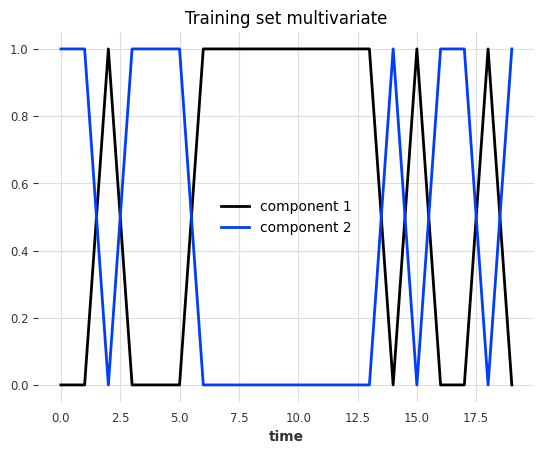

In [16]:
np.random.seed(40)

# create the train set
np_component1 = np.random.choice(a=[0, 1], size=100, p=[0.5, 0.5])
np_component2 = (np_component1 == 0).astype(float)
mts_train = TimeSeries.from_values(
    np.dstack((np_component1, np_component2))[0], columns=["component 1", "component 2"]
)

# visualize the train set
mts_train[:20].plot()
plt.title("Training set multivariate")
plt.show()

#### Test set

We create the test set using the same rules as the train set. Additionally, 6 separate anomalies of 3 different types will be injected in the series (2 anomalies per type). The anomalies can be longer than one timestamp. The types are:
- 1st type: replacing the current values of one component (0 or 1) with 2
- 2nd type: shifting the signal (both components) by 1 or -1 
- 3rd type: changing the current values of one component (0 or 1) to the other possible value (1 or 0)

In [17]:
# inject anomalies in the test timeseries
np.random.seed(3)
np_component1 = np.random.choice(a=[0, 1], size=100, p=[0.5, 0.5])
np_component2 = (np_component1 == 0).astype(int)

# 2 anomalies per type
# type 1: random values for only one component
np_component1[20:21] = 2
np_component2[30:32] = 2

# type 2: shift both components values (+/- 1 for both components)
np_component1[45:47] = np_component1[45:47] + 1
np_component2[45:47] = np_component2[45:47] + 1
np_component1[60:64] = np_component1[65:69] - 1
np_component2[60:64] = np_component2[65:69] - 1

# type 3: switch one state to another for only one component (1 to 0 for one component)
np_component1[75:82] = (np_component1[75:82] != True).astype(int)
np_component2[90:96] = (np_component2[90:96] != True).astype(int)

mts_test = TimeSeries.from_values(
    np.dstack((np_component1, np_component2))[0], columns=["component 1", "component 2"]
)

# create the anomalies binary ground truth series
anomalies_index = [
    20,
    30,
    31,
    45,
    46,
    60,
    61,
    62,
    63,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    90,
    91,
    92,
    93,
    94,
    95,
]
np_anomalies = np.zeros(len(mts_test))
np_anomalies[anomalies_index] = 1
mts_anomalies = TimeSeries.from_times_and_values(
    mts_test.time_index, np_anomalies, columns=["is_anomaly"]
)

The following plot shows the position of the 6 anomalies. From left to right, the first two anomalies correspond to the 1st type, the third and the fourth correspond to the 2nd type, and the last two to the 3rd type.


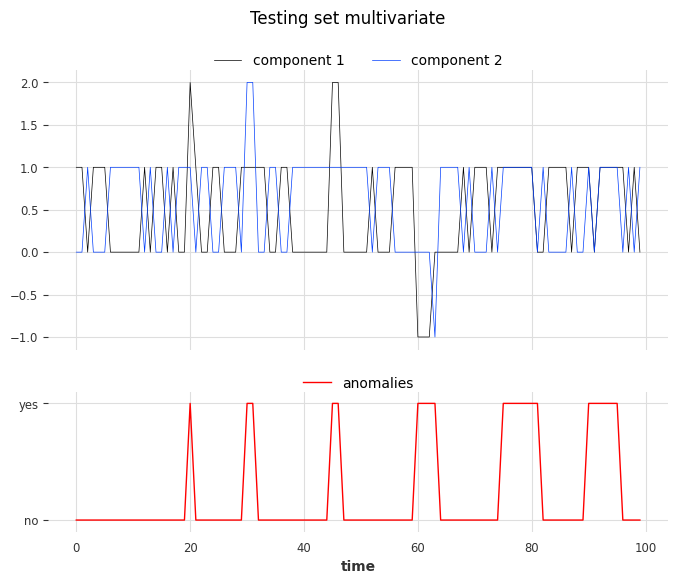

In [18]:
show_anomalies_from_scores(
    series=mts_test, actual_anomalies=mts_anomalies, title="Testing set multivariate"
)
plt.show()

### Use the scorer `KMeansScorer()`

We will use the `KMeansScorer` from the anomaly detection module to locate the anomalies. The scorer has the following parameters:
- `k`=2: The number of centroids to generate by the KMeans model.
- `window`=1 (default): Each timestamp will be considered independently by the KMeans model. It indicates the size of the window used to create the subsequences of the series.
- `component_wise`=False (default): The components will be concatenated in the rolling window. The KMeans model will then capture the relationship between the two components.  

The `KMeansScorer` must be fitted on the training series 'mts_train' with the function `fit()`.

The scorer will return the anomaly score of the series 'mts_test' with the function `score()`.

In [19]:
Kmeans_scorer = KMeansScorer(k=2, window=1, component_wise=False)

# fit the KmeansScorer on the train timeseries 'mts_train'
Kmeans_scorer.fit(mts_train)

/Users/julienadda/miniconda3/envs/con_darts2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


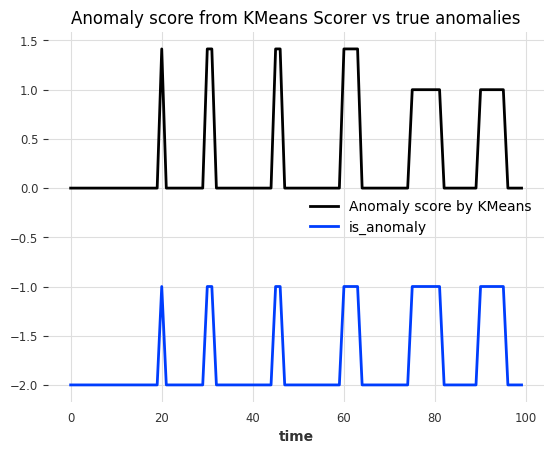

In [20]:
anomaly_score = Kmeans_scorer.score(mts_test)

# visualize the anomaly score compared to the true anomalies
anomaly_score.plot(label="Anomaly score by KMeans")
(mts_anomalies - 2).plot()
plt.title("Anomaly score from KMeans Scorer vs true anomalies")
plt.show()

We can see that the anomaly score accurately indicates the position of the 6 anomalies.

The scorer can evaluate its prediction accuracy thanks to the function `eval_accuracy()`. It takes as input the true anomalies, the series, and the name of the agnostic threshold metric (AUC-ROC or AUC-PR). It will return the accuracy of the indicated metric (value between 0 and 1). 

In [21]:
metric_auc_roc = Kmeans_scorer.eval_accuracy(mts_anomalies, mts_test, metric="AUC_ROC")
metric_auc_pr = Kmeans_scorer.eval_accuracy(mts_anomalies, mts_test, metric="AUC_PR")

print("AUC ROC: {}/1, AUC PR: {}/1".format(metric_auc_roc, metric_auc_pr))

AUC ROC: 1.0/1, AUC PR: 1.0/1


To visualize the results correctly, the scorer has a function, `show_anomalies()`, that returns a plot with all the information. 

It will show the following:
- the series 
- the anomaly score of the series 
- the accuracy of the indicated metric (default AUC_ROC)
- the actual anomalies (on a different plot)

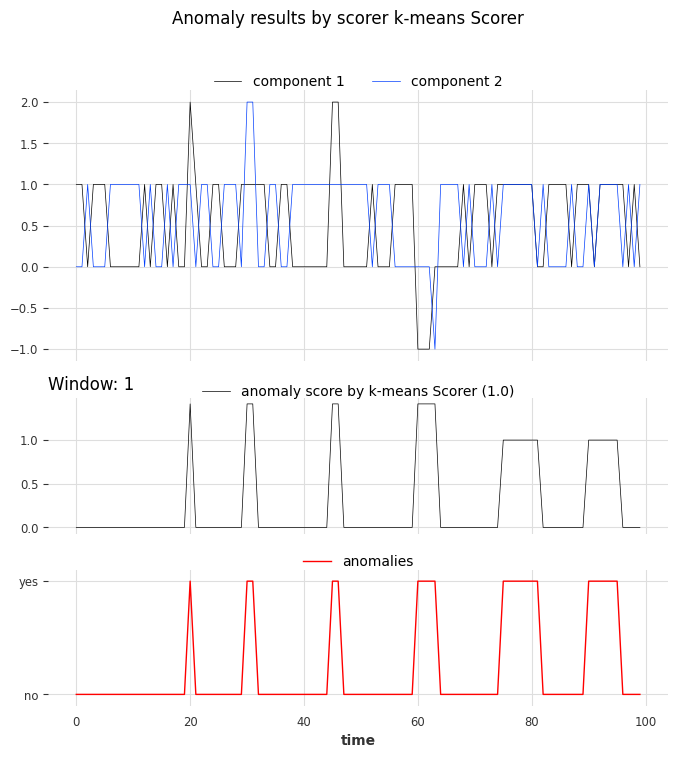

In [22]:
Kmeans_scorer.show_anomalies(
    series=mts_test, actual_anomalies=mts_anomalies, metric="AUC_ROC"
)
plt.show()

## Univariate case with window>1 

In the previous example, the parameter `window` was set to 1, sufficient to identify the anomalies. The following example will show the utility of using a higher value for the parameter when the anomalies are sequences with values that are not necessarily anomalous. 


### Synthetic data creation

#### Train set

The considered series is univariate (one component) and can take 4 possible values for each timestamp (0, 1, 2, and 3).
At each timestamp, the series has a 50 % chance to increase state (+1) or 50% to decrease state (-1). If the current value is 3 (is 0), and the next state is supposed to be +1 (-1), the next value will be set to 3 (to 0). The series is upper bounded/lower bounded by 3/0. 

As a result, a sequence will be considered anomalous if it contains a jump higher than two or if more than one consecutive timestamp is at value 1 or value 2. 


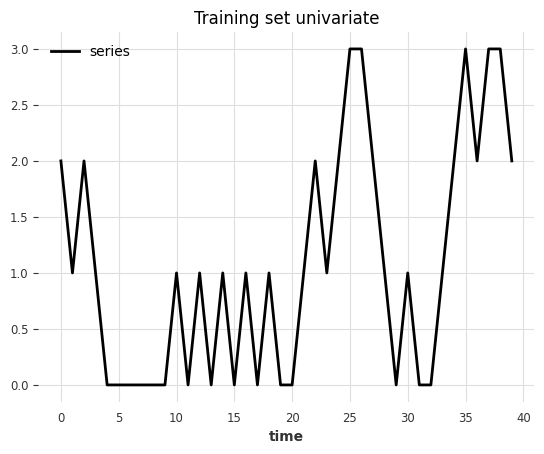

In [23]:
np.random.seed(1)

# create the train set
np_series = np.zeros(100)
np_series[0] = 2

for i in range(1, len(np_series)):
    np_series[i] = np_series[i - 1] + np.random.choice(a=[-1, 1], p=[0.5, 0.5])
    if np_series[i] > 3:
        np_series[i] = 3
    if np_series[i] < 0:
        np_series[i] = 0

ts_train = TimeSeries.from_values(np_series, columns=["series"])

# visualize the train set
ts_train[:40].plot()
plt.title("Training set univariate")
plt.show()

#### Test set

We create the test set using the same rules as the train set. Additionally, 6 separate anomalies of 2 different types will be injected in the series (3 anomalies per type). The anomalies can be longer than one timestamp. The types are:
- 1st type: sudden shift between states that are more than 1 step apart (ex: value 0 to value 2, or value 1 to value 3)  
- 2nd type: more than one consecutive timestamp that are at value 1 or value 2. 


In [24]:
np.random.seed(3)

# create the test set
np_series = np.zeros(100)

np_series[0] = 1

for i in range(1, len(np_series)):
    np_series[i] = np_series[i - 1] + np.random.choice(a=[-1, 1], p=[0.5, 0.5])
    if np_series[i] > 3:
        np_series[i] = 3
    if np_series[i] < 0:
        np_series[i] = 0


# 3 anomalies per type
# type 1: sudden shift between state 0 to state 2 without passing by value 1
np_series[23] = 3
np_series[44] = 3
np_series[91] = 0

# type 2: having consecutive timestamps at value 1 or 2
np_series[3:5] = 2
np_series[17:19] = 1
np_series[62:65] = 2

ts_test = TimeSeries.from_values(np_series, columns=["series"])

# create the anomalies binary ground truth series
anomalies_index = [4, 23, 18, 44, 63, 64, 91]
np_anomalies = np.zeros(100)
np_anomalies[anomalies_index] = 1
ts_anomalies = TimeSeries.from_times_and_values(
    ts_test.time_index, np_anomalies, columns=["is_anomaly"]
)

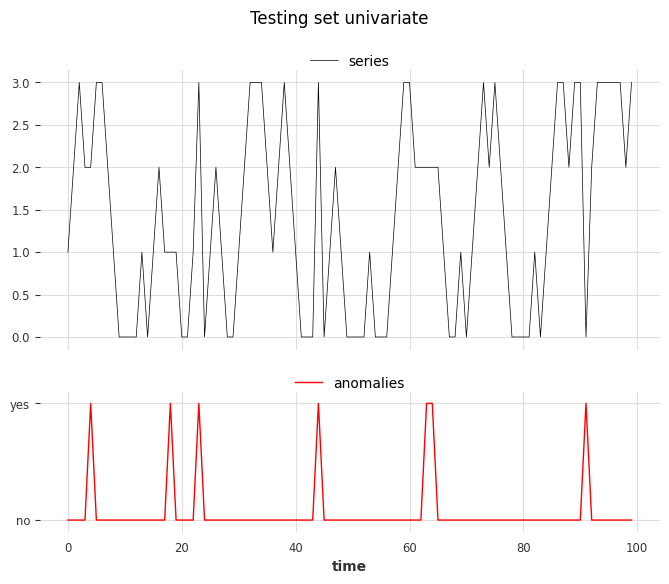

In [25]:
show_anomalies_from_scores(
    series=ts_test, actual_anomalies=ts_anomalies, title="Testing set univariate"
)
plt.show()

From left to right, anomalies at positions 1, 3, and 4 are of type 1, and anomalies at positions 2, 5, and 6 are of type 2. 

### Use the scorer `KMeansScorer()`

We fit two `KMeansScorer` with different values for the `window` parameter (1 and 2).

In [26]:
Kmeans_scorer_w1 = KMeansScorer(k=4, window=1)
Kmeans_scorer_w1.fit(ts_train)
score_w1 = Kmeans_scorer_w1.score(ts_test)

/Users/julienadda/miniconda3/envs/con_darts2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
Kmeans_scorer_w2 = KMeansScorer(k=8, window=2)
Kmeans_scorer_w2.fit(ts_train)
score_w2 = Kmeans_scorer_w2.score(ts_test)

/Users/julienadda/miniconda3/envs/con_darts2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
auc_roc_w1 = Kmeans_scorer_w1.eval_accuracy(ts_anomalies, ts_test, metric="AUC_ROC")
auc_pr_w1 = Kmeans_scorer_w1.eval_accuracy(ts_anomalies, ts_test, metric="AUC_PR")

auc_roc_w2 = Kmeans_scorer_w2.eval_accuracy(ts_anomalies, ts_test, metric="AUC_ROC")
auc_roc_w2 = Kmeans_scorer_w2.eval_accuracy(ts_anomalies, ts_test, metric="AUC_PR")

print(
    "For window 1: AUC ROC={}/1 and AUC PR={}/1".format(
        round(auc_roc_w1, 2), round(auc_pr_w1, 2)
    )
)
print(
    "For window 2: AUC ROC={}/1 and AUC PR={}/1".format(
        round(auc_roc_w2, 2), round(auc_roc_w2, 2)
    )
)

For window 1: AUC ROC=0.42/1 and AUC PR=0.06/1
For window 2: AUC ROC=0.89/1 and AUC PR=0.89/1


The metric indicates that the scorer with the parameter window set to 1 cannot locate the anomalies. On the other hand, the scorer with the parameter set to 2 locates the anomalies with great precision.  


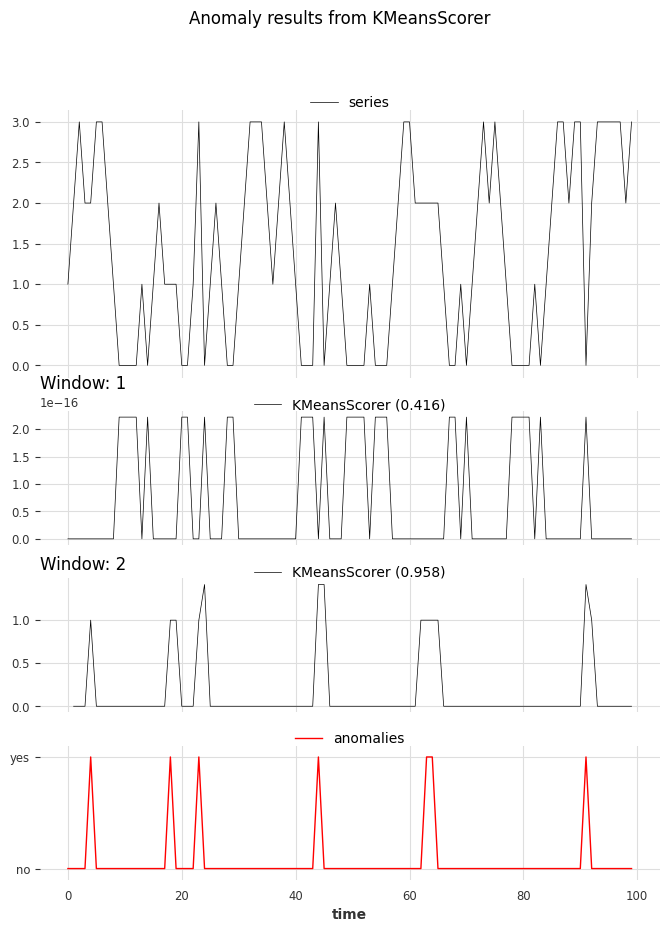

In [29]:
show_anomalies_from_scores(
    series=ts_test,
    actual_anomalies=ts_anomalies,
    anomaly_scores=[score_w1, score_w2],
    names_of_scorers=["KMeansScorer", "KMeansScorer"],
    window=[1, 2],
    metric="AUC_ROC",
    title="Anomaly results from KMeansScorer",
)
plt.show()

We can see the accurate prediction of the scorer with a window of 2 compared to that of the scorer with a window of 1. 